In [1]:
import pandas as pd
import seaborn as sns
import numpy as np

import matplotlib.pyplot as plt
import matplotlib as mpl
import matplotlib.gridspec as gridSpec

from sklearn.preprocessing import StandardScaler, MinMaxScaler, RobustScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split

%matplotlib inline

In [2]:
data_path = "../data/Customer-Churn-Records.csv"
data = pd.read_csv(data_path)
data.head()

,RowNumber,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited,Complain,Satisfaction Score,Card Type,Point Earned
0,1,15634602,Hargrave,619,France,Female,42,2,0.00,1,1,1,101348.88,1,1,2,DIAMOND,464
1,2,15647311,Hill,608,Spain,Female,41,1,83807.86,1,0,1,112542.58,0,1,3,DIAMOND,456
2,3,15619304,Onio,502,France,Female,42,8,159660.80,3,1,0,113931.57,1,1,3,DIAMOND,377
3,4,15701354,Boni,699,France,Female,39,1,0.00,2,0,0,93826.63,0,0,5,GOLD,350
4,5,15737888,Mitchell,850,Spain,Female,43,2,125510.82,1,1,1,79084.10,0,0,5,GOLD,425


# Data Preprocessing

In [3]:
data.drop(['RowNumber', 'Surname', 'CustomerId'], axis = 1, inplace = True)

In [4]:
def resumetable(df):    
    print(f'data shape: {df.shape}')
    summary = pd.DataFrame(df.dtypes, columns = ['data type'])
    summary = summary.rename(columns = {'index': 'feature'})
    summary['num_NaN'] = df.isnull().sum().values
    summary['num_unique'] = df.nunique().values
    summary['data category'] = None
    for col in df.columns:
        if col == 'Exited':
            summary.loc[col, 'data category'] = 'Binary'
        elif df[col].dtype == object:
            summary.loc[col, 'data category'] = 'Categorical'
        elif df[col].dtype == float:
            summary.loc[col, 'data category'] = 'Numeric'
        elif df[col].dtype == int:
            summary.loc[col, 'data category'] = 'Integer'

    
    return summary

In [5]:
summary = resumetable(data)
summary

data shape: (10000, 15)


,data type,num_NaN,num_unique,data category
CreditScore,int64,0,460,Integer
Geography,object,0,3,Categorical
Gender,object,0,2,Categorical
Age,int64,0,70,Integer
Tenure,int64,0,11,Integer
Balance,float64,0,6382,Numeric
NumOfProducts,int64,0,4,Integer
HasCrCard,int64,0,2,Integer
IsActiveMember,int64,0,2,Integer
EstimatedSalary,float64,0,9999,Numeric


We can conclude that this dataset does not include any missing values. Additionally, we identified some categorical variables (Geography, Gender, Card Type). We also need to simplify the column names for easier recognition

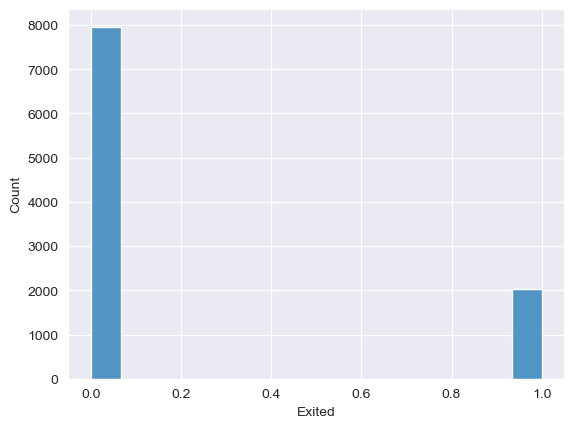

In [6]:
sns.histplot(data['Exited']);

Here, the plot suggests that the target variable is in an inbalance status, so we should focus more on the small proportion of target value 1. 

In [7]:
data['Exited'].value_counts()

Exited
0    7962
1    2038
Name: count, dtype: int64

We have a binary outcome here: 1 indicates that the customer left the bank, while 0 means the customer did not. The results suggest that the number of customers who left the bank is four times greater than the number of customers who did not churn based on this dataset.

### One-hot encoding (categorical data)

In [8]:
data = pd.get_dummies(data, columns=['Geography', 'Gender', 'Card Type'])

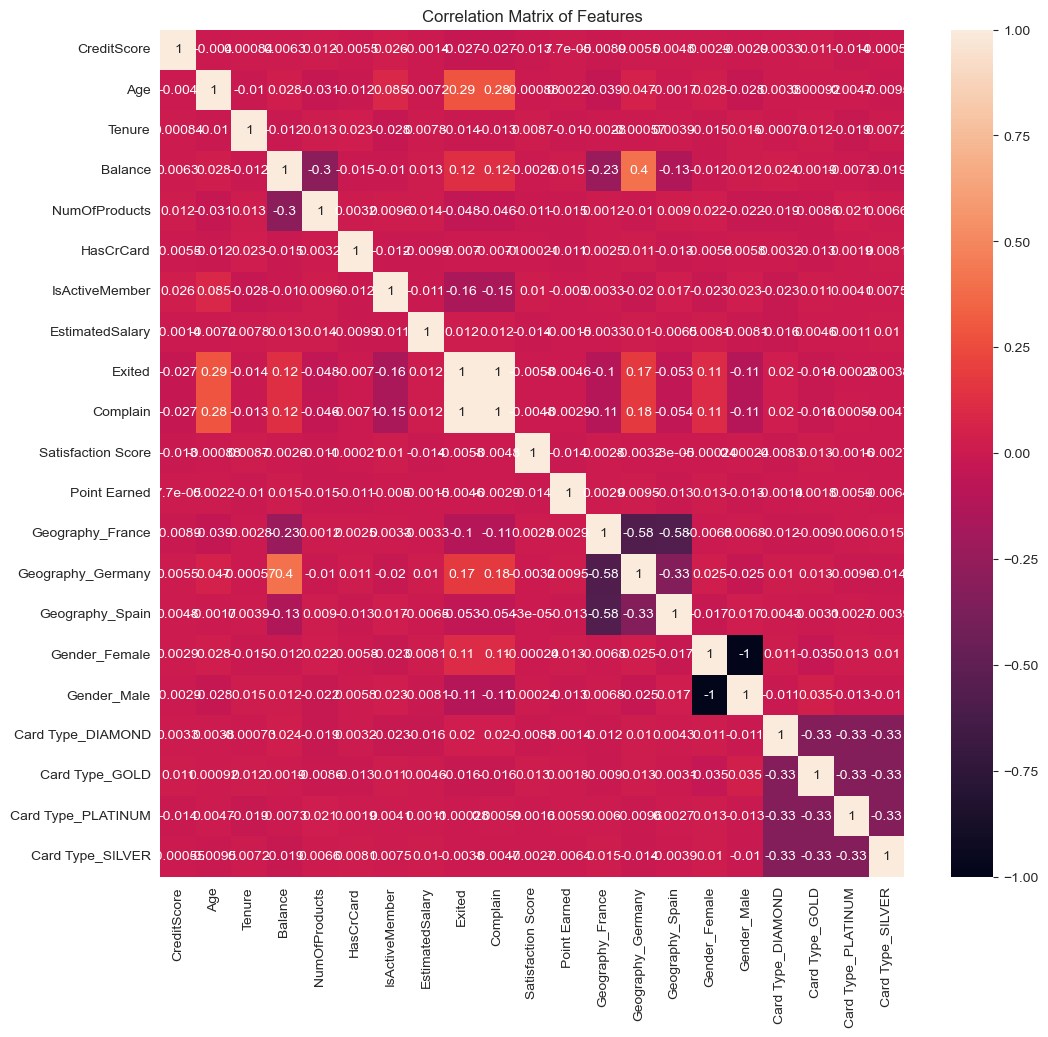

In [9]:
corr_matrix = data.corr()

plt.figure(figsize=(12, 11))
sns.heatmap(corr_matrix, annot=True)
plt.title('Correlation Matrix of Features')
plt.show()

In [10]:
data.drop(['Complain'], axis = 1, inplace = True)

Complain 과 Excited correlation score 가 1이므로 drop 

### Data Scaling

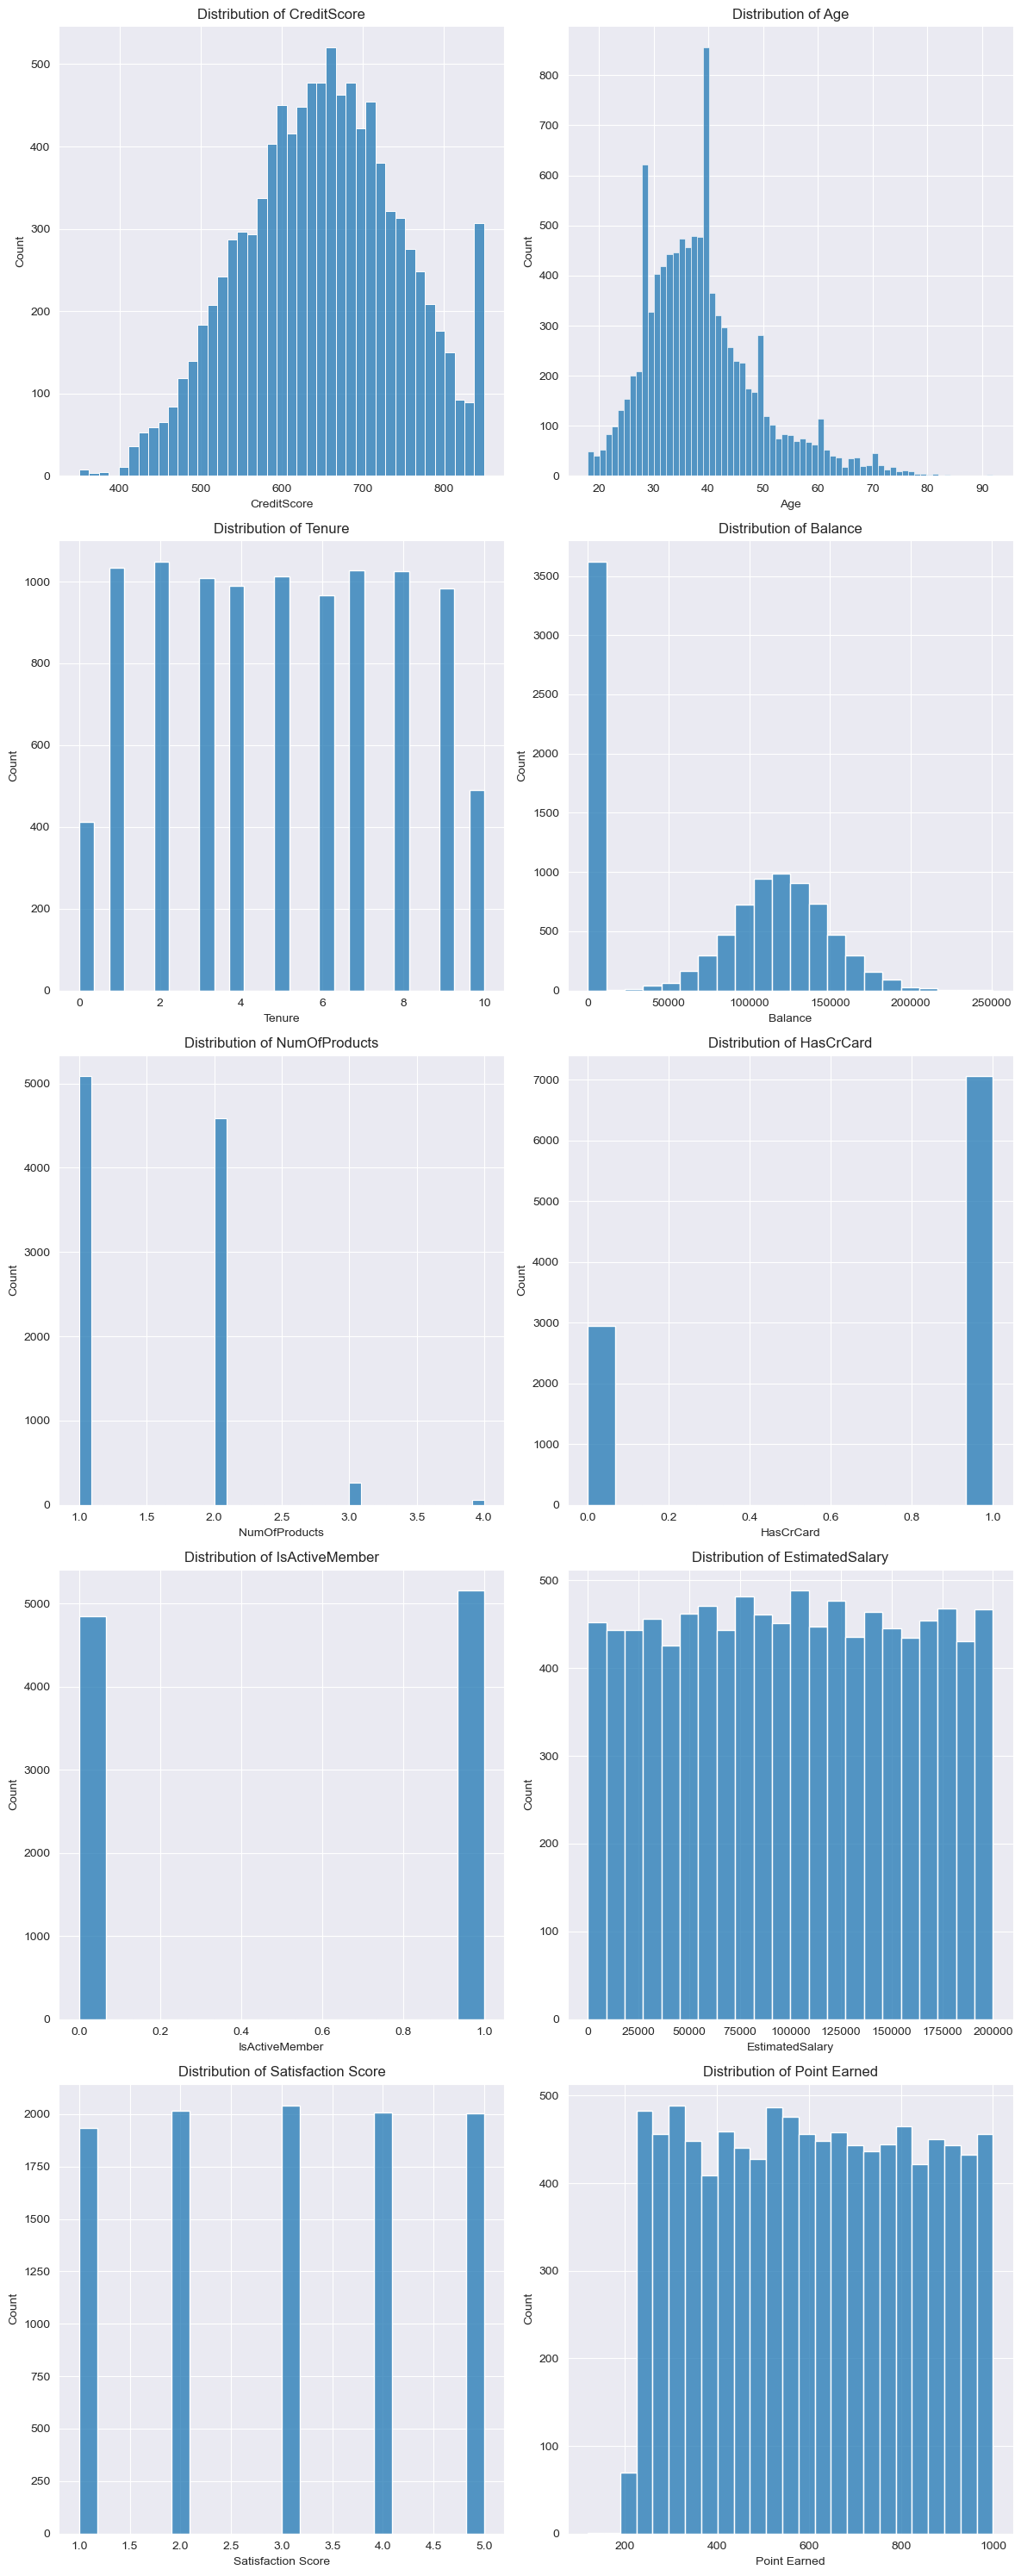

In [11]:
numeric_columns = summary[summary['data category'].isin(['Numeric', 'Integer'])].index.tolist()

if "Complain" in numeric_columns:
     numeric_columns.remove("Complain")

fig, axes = plt.subplots(len(numeric_columns) // 2 + len(numeric_columns) % 2, 2, figsize=(12, 30))
axes = axes.flatten()

for i, col in enumerate(numeric_columns):
    sns.histplot(data[col],ax=axes[i])
    axes[i].set_title(f'Distribution of {col}')

for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()

- numofproducts 변수는 1, 2, 3, 4 등의 숫자간에 discrete 성격을 보여주기때문에 범주형 변수로 간주한다.
satisfaction score 변수도 명확한 범주를 보여줌. (1, 2, 3, 4, 5) 
이 두 변수는 원-핫 인코딩을 진행

- Balance 변수를 보면 0에 많은 데이터가 몰려있는 걸 알 수 있다. 이는 모델이 잔액 0 여부를 구분하도록 하기 위해 이진 변수로 추가

- CreditScore: Standard Scaling 

- Age: Standard Scaling 
    WHY? Age는 정규 분포에 가깝고 나이 간의 상대적 차이를 유지하는게 중요해보임. 그리고 30~40대에 몰려있는게 가장 큰 이유

- EstimatedSalary: Min-Max Scaling 
    WHY? 분포가 다른 피처들 중 가장 균등함
  
- Point Earned: Robust Scaling 
    WHY? Point Earned는 최소값 근처에 데이터가 적고 나머지 값들은 균등하게 분포되어 있어 이상치의 영향을 줄이기 위해 Robust Scaling 사용

- Balance: Robust Scaling 
    WHY? Balance는 0에 많은 데이터가 몰려 있어서 중앙값과 IQR을 기준으로 스케일링하여 이상치의 영향을 줄이기


In [12]:
data = pd.get_dummies(data, columns=['NumOfProducts', 'Satisfaction Score'])

In [13]:
data.describe()

,CreditScore,Age,Tenure,Balance,HasCrCard,IsActiveMember,EstimatedSalary,Exited,Point Earned
count,10000.000000,10000.000000,10000.000000,10000.000000,10000.00000,10000.000000,10000.000000,10000.000000,10000.000000
mean,650.528800,38.921800,5.012800,76485.889288,0.70550,0.515100,100090.239881,0.203800,606.515100
std,96.653299,10.487806,2.892174,62397.405202,0.45584,0.499797,57510.492818,0.402842,225.924839
min,350.000000,18.000000,0.000000,0.000000,0.00000,0.000000,11.580000,0.000000,119.000000
25%,584.000000,32.000000,3.000000,0.000000,0.00000,0.000000,51002.110000,0.000000,410.000000
50%,652.000000,37.000000,5.000000,97198.540000,1.00000,1.000000,100193.915000,0.000000,605.000000
75%,718.000000,44.000000,7.000000,127644.240000,1.00000,1.000000,149388.247500,0.000000,801.000000
max,850.000000,92.000000,10.000000,250898.090000,1.00000,1.000000,199992.480000,1.000000,1000.000000


In [14]:
standard_scaler = StandardScaler()
min_max_scaler = MinMaxScaler()
robust_scaler = RobustScaler()

data[['CreditScore', 'Age']] = standard_scaler.fit_transform(data[['CreditScore', 'Age']])
data['EstimatedSalary'] = min_max_scaler.fit_transform(data[['EstimatedSalary']])
data[['Point Earned', 'Balance']] = robust_scaler.fit_transform(data[['Point Earned', 'Balance']])

In [15]:
data.head()

,CreditScore,Age,Tenure,Balance,HasCrCard,IsActiveMember,EstimatedSalary,Exited,Point Earned,Geography_France,...,Card Type_SILVER,NumOfProducts_1,NumOfProducts_2,NumOfProducts_3,NumOfProducts_4,Satisfaction Score_1,Satisfaction Score_2,Satisfaction Score_3,Satisfaction Score_4,Satisfaction Score_5
0,-0.326221,0.293517,2,-0.761480,1,1,0.506735,1,-0.360614,True,...,False,True,False,False,False,False,True,False,False,False
1,-0.440036,0.198164,1,-0.104906,0,1,0.562709,0,-0.381074,False,...,False,True,False,False,False,False,False,True,False,False
2,-1.536794,0.293517,8,0.489346,1,0,0.569654,1,-0.583120,True,...,False,False,False,True,False,False,False,True,False,False
3,0.501521,0.007457,1,-0.761480,0,0,0.469120,0,-0.652174,True,...,False,False,True,False,False,False,False,False,False,True
4,2.063884,0.388871,2,0.221806,1,1,0.395400,0,-0.460358,False,...,False,True,False,False,False,False,False,False,False,True


### Feature Engineering

In [16]:
data['Zero_Balance'] = (data['Balance'] == 0).astype(int)

In [17]:
data

,CreditScore,Age,Tenure,Balance,HasCrCard,IsActiveMember,EstimatedSalary,Exited,Point Earned,Geography_France,...,NumOfProducts_1,NumOfProducts_2,NumOfProducts_3,NumOfProducts_4,Satisfaction Score_1,Satisfaction Score_2,Satisfaction Score_3,Satisfaction Score_4,Satisfaction Score_5,Zero_Balance
0,-0.326221,0.293517,2,-0.761480,1,1,0.506735,1,-0.360614,True,...,True,False,False,False,False,True,False,False,False,0
1,-0.440036,0.198164,1,-0.104906,0,1,0.562709,0,-0.381074,False,...,True,False,False,False,False,False,True,False,False,0
2,-1.536794,0.293517,8,0.489346,1,0,0.569654,1,-0.583120,True,...,False,False,True,False,False,False,True,False,False,0
3,0.501521,0.007457,1,-0.761480,0,0,0.469120,0,-0.652174,True,...,False,True,False,False,False,False,False,False,True,0
4,2.063884,0.388871,2,0.221806,1,1,0.395400,0,-0.460358,False,...,True,False,False,False,False,False,False,False,True,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9995,1.246488,0.007457,5,-0.761480,1,0,0.481341,0,-0.780051,True,...,False,True,False,False,True,False,False,False,False,0
9996,-1.391939,-0.373958,10,-0.312031,1,1,0.508490,0,0.424552,True,...,True,False,False,False,False,False,False,False,True,0
9997,0.604988,-0.278604,7,-0.761480,0,1,0.210390,1,-0.104859,True,...,True,False,False,False,False,False,True,False,False,0
9998,1.256835,0.293517,3,-0.173319,1,0,0.464429,1,-0.680307,False,...,False,True,False,False,False,True,False,False,False,0


In [18]:
bins = [0, 2, 4, 6, 8, 10]
labels = ['0-2', '3-4', '5-6', '7-8', '9-10']
data['Tenure_bin'] = pd.cut(data['Tenure'], bins = bins, labels = labels, include_lowest = True)
data = pd.get_dummies(data, columns = ['Tenure_bin'], prefix = 'tenure')

In [19]:
data.head()

,CreditScore,Age,Tenure,Balance,HasCrCard,IsActiveMember,EstimatedSalary,Exited,Point Earned,Geography_France,...,Satisfaction Score_2,Satisfaction Score_3,Satisfaction Score_4,Satisfaction Score_5,Zero_Balance,tenure_0-2,tenure_3-4,tenure_5-6,tenure_7-8,tenure_9-10
0,-0.326221,0.293517,2,-0.761480,1,1,0.506735,1,-0.360614,True,...,True,False,False,False,0,True,False,False,False,False
1,-0.440036,0.198164,1,-0.104906,0,1,0.562709,0,-0.381074,False,...,False,True,False,False,0,True,False,False,False,False
2,-1.536794,0.293517,8,0.489346,1,0,0.569654,1,-0.583120,True,...,False,True,False,False,0,False,False,False,True,False
3,0.501521,0.007457,1,-0.761480,0,0,0.469120,0,-0.652174,True,...,False,False,False,True,0,True,False,False,False,False
4,2.063884,0.388871,2,0.221806,1,1,0.395400,0,-0.460358,False,...,False,False,False,True,0,True,False,False,False,False


### Feature importance by random forest

In [20]:
X = data.drop('Exited', axis=1)
y = data['Exited']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

model = RandomForestClassifier()
model.fit(X_train, y_train)

importances = model.feature_importances_
feature_importance_df = pd.DataFrame({'Feature': X.columns, 'Importance': importances})
feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=False)

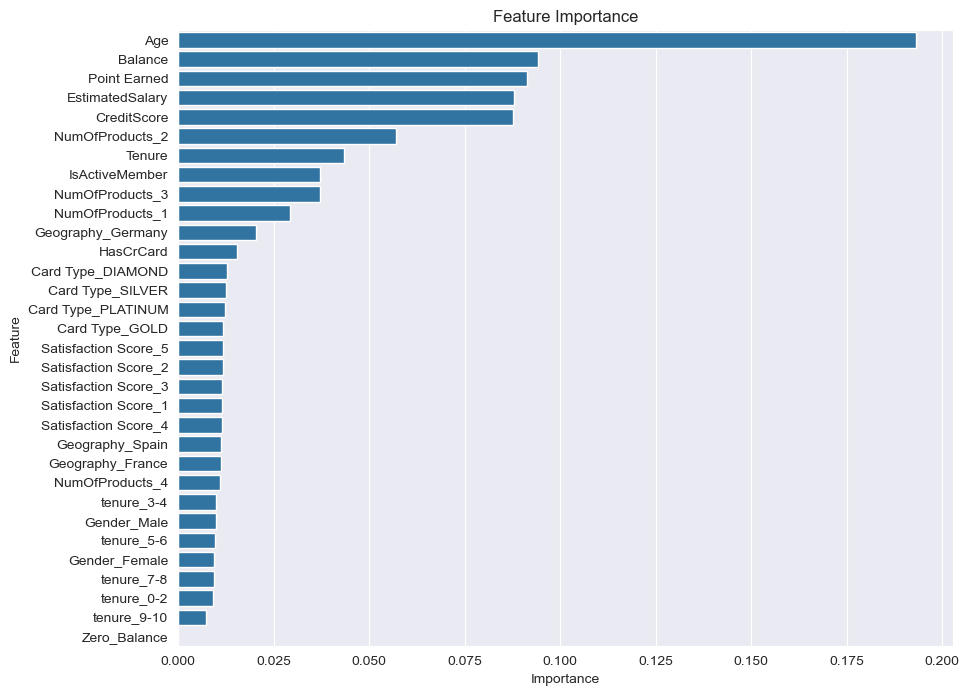

In [21]:
plt.figure(figsize=(10, 8))
sns.barplot(feature_importance_df, x = 'Importance', y = 'Feature')
plt.title('Feature Importance')
plt.show();